In [1]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy as np 
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import io 
import PIL
import freud
import matplotlib.pyplot as plt 

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [2]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    vertices = [
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)

    geometry = fresnel.geometry.Polygon(
        scene, vertices = vertices, N=len(snapshot.particles.position)
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([100 / 255, 216 / 255, 230 / 255]), roughness=0.2
    )
    positions = np.array(snapshot.particles.position)[:, :2]
    geometry.position[:] = positions

    orientations = np.array(snapshot.particles.orientation)
    angles = 2 * np.arctan2(orientations[:, 3], orientations[:, 0])
    geometry.angle[:] = angles
    
    geometry.outline_width = 0.01

    fresnel.geometry.Box(scene, [L, L, 0.1, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(0, 0, 10), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [3]:
m = 5
N_particles = m**2
spacing = 1
K = math.ceil(N_particles ** (1 / 2))
L = K * spacing 
x = np.linspace(-L / 2, L / 2, K, endpoint=False)
position = [(px, py, 0) for px, py in itertools.product(x, x)][:N_particles]
orientation = [(1, 0, 0, 0)] * N_particles

# Create GSD snapshot
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position
frame.particles.orientation = orientation
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, 0, 0, 0, 0]
frame.particles.types = ['Hat_Tile']


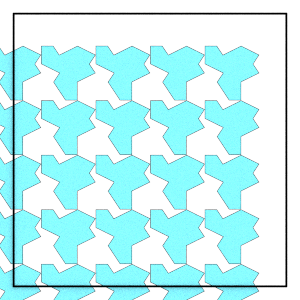

In [4]:
render(frame)

In [5]:
fn = os.path.join(os.getcwd(), 'tile_lattice.gsd')
![ -e "$fn" ] && rm "$fn"

with gsd.hoomd.open(name='tile_lattice.gsd', mode='x') as f:
    f.append(frame)

In [6]:
cpu = hoomd.device.CPU()

In [7]:
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='tile_lattice.gsd')

In [8]:
fn = os.path.join(os.getcwd(), 'trajectory_expansion.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_expansion.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [ ]:
def shoelace_area():
    vertices = [
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
    n = len(vertices)
    area = 0.5 * abs(sum(vertices[i][0] * vertices[(i + 1) % n][1] - vertices[i][1] * vertices[(i + 1) % n][0] for i in range(n)))
    return area

area = shoelace_area()
area


0.592948717948718

In [ ]:
def expand(simulation, betaP, weight, target, run_steps, log_interval=100):
    mc = hoomd.hpmc.integrate.ConvexPolygon()
    mc.shape['Hat_Tile'] = dict(
        vertices=[
            (0.1709401709401709,-0.5899408284023668),
            (0.1709401709401709,-0.2553254437869822),
            (0.5042735042735043,-0.08994082840236695),
            (0.3931623931623931,0.07544378698224852),
            (0.5042735042735043,0.2446745562130177),
            (0.1709401709401709,0.41005917159763317),
            (-0.16239316239316243,0.2446745562130177),
            (-0.27350427350427353,0.41005917159763317),
            (-0.49572649572649574,0.41005917159763317),
            (-0.49572649572649574,0.07544378698224852),
            (-0.16239316239316243,-0.08994082840236695),
            (-0.27350427350427353,-0.2553254437869822),
            (-0.05128205128205132,-0.5899408284023668)
        ]
    )
    simulation.operations.integrator = mc

    volume_particle = area
    target_rho = target / volume_particle

    boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(10),
        betaP=betaP
    )
    boxmc.volume = dict(mode='standard', weight=weight, delta=-1.5)  
    simulation.operations.updaters.append(boxmc)

    volume_fractions = []
    pressures = []
    
    for step in range(0, run_steps, log_interval):
        simulation.run(log_interval)
        
        current_vf = (simulation.state.N_particles * volume_particle) / simulation.state.box.volume
        current_pressure = betaP / current_vf
        
        volume_fractions.append(current_vf)
        pressures.append(current_pressure)
        
        print(f"Pressure {current_pressure}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

        if current_vf <= target:
            break

    return volume_fractions, pressures


In [14]:

vf, pressure = expand(simulation=simulation, betaP=0.05, weight=0.05, target=0.05, run_steps=10_00000)

Pressure 0.49016712968248727: Overlaps = 0, Volume Fraction = 0.10200602401141874
Pressure 0.47988212853015294: Overlaps = 0, Volume Fraction = 0.10419225269577485
Pressure 0.4844326700602979: Overlaps = 0, Volume Fraction = 0.10321351777074912
Pressure 0.48951743548984805: Overlaps = 0, Volume Fraction = 0.10214140779268921
Pressure 0.4927745704231893: Overlaps = 0, Volume Fraction = 0.1014662748466516
Pressure 0.4925771022514422: Overlaps = 0, Volume Fraction = 0.10150695144265329
Pressure 0.4812913460497551: Overlaps = 0, Volume Fraction = 0.10388717854659096
Pressure 0.4674445384390837: Overlaps = 0, Volume Fraction = 0.10696456132948463
Pressure 0.5048637932530003: Overlaps = 0, Volume Fraction = 0.09903661278190275
Pressure 0.5280444633645177: Overlaps = 0, Volume Fraction = 0.0946889958497381
Pressure 0.529607925294026: Overlaps = 0, Volume Fraction = 0.09440946332561237
Pressure 0.534401500655814: Overlaps = 0, Volume Fraction = 0.09356261151707158
Pressure 0.5520541585623144: 

In [15]:
vf_c = (simulation.state.N_particles * area) / simulation.state.box.volume
vf_c

0.049846251233989745

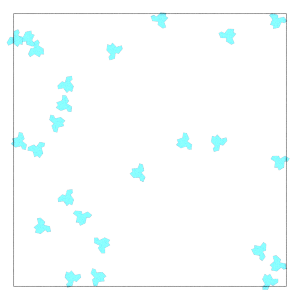

In [16]:
render(simulation.state.get_snapshot())

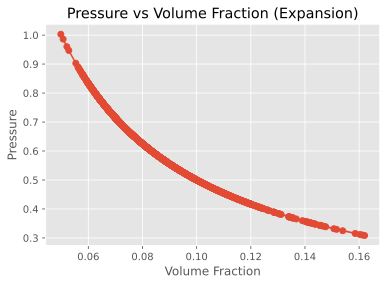

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(vf, pressure, marker='o')
plt.xlabel('Volume Fraction')
plt.ylabel('Pressure')
plt.title('Pressure vs Volume Fraction (Expansion)')
plt.show()

In [18]:
gsd_writer.flush()

In [19]:
del(simulation)

In [66]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_expansion.gsd')

In [67]:
fn = os.path.join(os.getcwd(), 'trajectory_compress.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_compress.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [68]:
def compress(simulation, betaP, weight, run_steps, target, log_interval=100):
    mc = hoomd.hpmc.integrate.ConvexPolygon()
    mc.shape['Hat_Tile'] = dict(
        vertices=[
            (0.1709401709401709,-0.5899408284023668),
            (0.1709401709401709,-0.2553254437869822),
            (0.5042735042735043,-0.08994082840236695),
            (0.3931623931623931,0.07544378698224852),
            (0.5042735042735043,0.2446745562130177),
            (0.1709401709401709,0.41005917159763317),
            (-0.16239316239316243,0.2446745562130177),
            (-0.27350427350427353,0.41005917159763317),
            (-0.49572649572649574,0.41005917159763317),
            (-0.49572649572649574,0.07544378698224852),
            (-0.16239316239316243,-0.08994082840236695),
            (-0.27350427350427353,-0.2553254437869822),
            (-0.05128205128205132,-0.5899408284023668)
        ]
    )
    simulation.operations.integrator = mc

    boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(10),
        betaP=betaP
    )
    boxmc.volume = dict(mode='standard', weight=weight, delta=1)
    simulation.operations.updaters.append(boxmc)

    volume_fractions = []
    pressures = []
    
    for step in range(0, run_steps, log_interval):
        simulation.run(log_interval)
        
        current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
        current_pressure = betaP / current_vf
        
        volume_fractions.append(current_vf)
        pressures.append(current_pressure)

        print(f"Step {step}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}, Pressure {current_pressure}")

        if current_vf >= target:
            break

    
    return volume_fractions, pressures


In [69]:
vf, pressure = compress(simulation=simulation, betaP=1.5, weight=0.5, target=0.7, run_steps=1000000)

Step 0: Overlaps = 0, Volume Fraction = 0.05291440560146444, Pressure 28.34766795449908
Step 100: Overlaps = 0, Volume Fraction = 0.0529683558605223, Pressure 28.318794790418647
Step 200: Overlaps = 0, Volume Fraction = 0.05340370970909402, Pressure 28.087936365674757
Step 300: Overlaps = 0, Volume Fraction = 0.05363149014134236, Pressure 27.968642975364773
Step 400: Overlaps = 0, Volume Fraction = 0.05426696236546172, Pressure 27.64112702491483
Step 500: Overlaps = 0, Volume Fraction = 0.054258741125458, Pressure 27.645315185836584
Step 600: Overlaps = 0, Volume Fraction = 0.05401366469914295, Pressure 27.77075038983239
Step 700: Overlaps = 0, Volume Fraction = 0.05416703014411473, Pressure 27.692121868397756
Step 800: Overlaps = 0, Volume Fraction = 0.05468294288202706, Pressure 27.43085724621842
Step 900: Overlaps = 0, Volume Fraction = 0.055011652257651165, Pressure 27.26695051758559
Step 1000: Overlaps = 0, Volume Fraction = 0.0551686056216761, Pressure 27.18937669526018
Step 1100

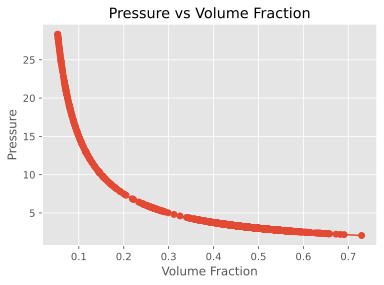

In [70]:
plt.figure(figsize=(6, 4))
plt.plot(vf, pressure, marker='o')
plt.xlabel('Volume Fraction')
plt.ylabel('Pressure')
plt.title('Pressure vs Volume Fraction')
plt.show()

In [71]:
gsd_writer.flush()

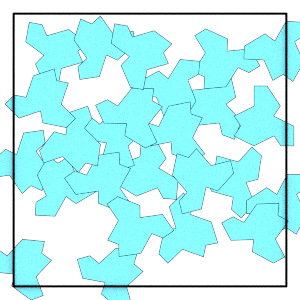

In [72]:
render(simulation.state.get_snapshot())